# Time Series Traditional Analysis
### Forecasting with Moving Average
We'll use the differenced series to model with moving average (MA) and exponential moving average.

In [125]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning)

merged_df = pd.read_csv('../data/merged_df.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()
t_df = pd.read_csv('../data/t.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()
v_df = pd.read_csv('../data/v.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()

We established in a previous notebook that the series is not stationary. We'll use the differenced series to model with moving average (MA) and exponential moving average.

In [126]:
from typing import Union
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import KPSS, PhillipsPerron, ZivotAndrews, VarianceRatio


def test_stationarity_robust(timeseries: Union[pd.Series, np.ndarray]) -> None:
    """
    Perform robust stationarity tests on a time series.

    This function applies four different stationarity tests:
    1. Augmented Dickey-Fuller (ADF) test
    2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
    3. Phillips-Perron test
    4. Zivot-Andrews test (if the series has more than 100 observations)

    Args:
        timeseries (Union[pd.Series, np.ndarray]): The time series to test for stationarity.

    Raises:
        ValueError: If the input is not a pandas Series or numpy array.
        RuntimeError: If any of the statistical tests fail to run.

    Returns:
        None: Results are printed to the console.
    """
    """if not isinstance(timeseries, (pd.Series, np.ndarray)):
        raise ValueError("Input must be a pandas Series or numpy array.")"""

    try:
        # ADF test
        ADF_result = adfuller(timeseries)
        print(f"ADF Statistic: {ADF_result[0]:.6f}")
        print(f"p-value: {ADF_result[1]:.6f}")
        if ADF_result[1] < 0.05:
            print(
                "Reject the null hypothesis that there is a unit root. The time series may be stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that there is a unit root. The time series is non-stationary."
            )

        # KPSS test (statsmodels implementation)
        KPSS_result = kpss(timeseries)
        print(f"\nKPSS Statistic (statsmodels): {KPSS_result[0]:.6f}")
        print(f"p-value: {KPSS_result[1]:.6f}")
        if KPSS_result[1] < 0.05:
            print(
                "Reject the null hypothesis that the time series is stationary. The time series is non-stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that the time series is stationary. The time series is stationary."
            )

        # KPSS test (arch implementation)
        kpss_arch_result = kpss(timeseries)

        # Display the results
        print(
            f"\nKPSS Statistic (arch): {kpss_arch_result[0]}"
        )  # This line gives me the error AttributeError: 'tuple' object has no attribute 'stat'
        print(f"P-Value: {kpss_arch_result[1]}")
        print("Critical Values:")
        for key, value in kpss_arch_result[3].items():
            print(f"   {key}: {value}")

        # Interpretation:
        if kpss_arch_result[1] < 0.05:
            print("The series is likely non-stationary.")
        else:
            print("The series is likely stationary.")

        # Phillips-Perron test
        PP_result = PhillipsPerron(timeseries)
        print(f"\nPhillips-Perron Statistic: {PP_result.stat:.6f}")
        print(f"p-value: {PP_result.pvalue:.6f}")
        if PP_result.pvalue < 0.05:
            print(
                "Reject the null hypothesis that there is a unit root. The time series may be stationary."
            )
        else:
            print(
                "Fail to reject the null hypothesis that there is a unit root. The time series is non-stationary."
            )

        # Zivot-Andrews test
        if len(timeseries) > 100:
            ZA_result = ZivotAndrews(timeseries)
            print(f"\nZivot-Andrews Statistic: {ZA_result.stat:.6f}")
            print(f"p-value: {ZA_result.pvalue:.6f}")
            if ZA_result.pvalue < 0.05:
                print(
                    "Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary."
                )
            else:
                print(
                    "Fail to reject the null hypothesis that there is a unit root with a single structural break. The time series is non-stationary."
                )
        else:
            print(
                "\nToo few observations to run the Zivot-Andrews test with trend c and 10 lags."
            )

        # Variance Ratio test
        VR_result = VarianceRatio(timeseries, lags=2)
        # print(VR_result.summary().as_text())
        print(f"\nVariance Ratio statistic: {VR_result.stat:.4f}")
        print(f"P-value: {VR_result.pvalue:.4f}")
        if VR_result.pvalue < 0.05:
            print(
                "Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test."
            )
        else:
            print(
                "Fail to reject the null hypothesis. The series may follow a random walk per the Variance Ratio Test."
            )

    except Exception as e:
        raise RuntimeError(f"An error occurred during the statistical tests: {str(e)}")

In [127]:
test_stationarity_robust(merged_df['t_diff'])

ADF Statistic: -7.654336
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

KPSS Statistic (statsmodels): 0.119698
p-value: 0.100000
Fail to reject the null hypothesis that the time series is stationary. The time series is stationary.

KPSS Statistic (arch): 0.1196980864318628
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary.

Phillips-Perron Statistic: -33.161193
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

Zivot-Andrews Statistic: -8.011211
p-value: 0.000010
Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary.

Variance Ratio statistic: -5.7310
P-value: 0.0000
Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test.


In [128]:
test_stationarity_robust(merged_df['v_diff'])

ADF Statistic: -7.428179
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

KPSS Statistic (statsmodels): 0.028200
p-value: 0.100000
Fail to reject the null hypothesis that the time series is stationary. The time series is stationary.

KPSS Statistic (arch): 0.02819964765577932
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary.

Phillips-Perron Statistic: -34.365838
p-value: 0.000000
Reject the null hypothesis that there is a unit root. The time series may be stationary.

Zivot-Andrews Statistic: -7.758678
p-value: 0.000010
Reject the null hypothesis that there is a unit root with a single structural break. The time series may be stationary.

Variance Ratio statistic: -6.6542
P-value: 0.0000
Reject the null hypothesis of a random walk. The series is not a random walk per the Variance Ratio Test.


Next, we check the ACF plot to determine the order of the MA model.

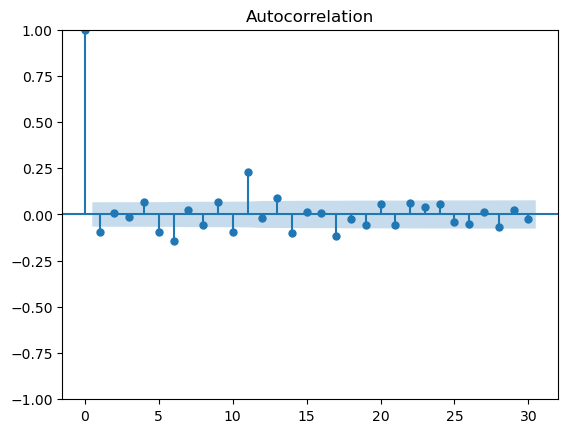

In [129]:
plot_acf(merged_df['t_diff'], lags=30)
plt.show()

If we're being charitable, this looks like a `MA(1)` model. The mildly significant spikes up to around lag 16 suggest that this is not a straightforward dataset. Let's check the Verizon differenced time series' ACF plot.

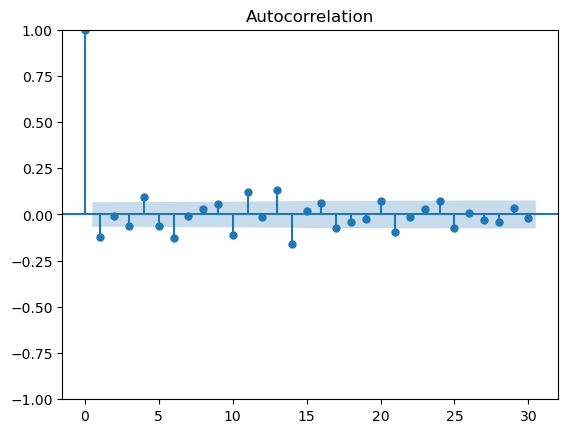

In [130]:
plot_acf(merged_df["v_diff"], lags=30)
plt.show()

The same pattern is observed in the Verizon series. We'll use a `MA(1)` model for both series. Before we apply the moving average models, let's look at the overall data to get an idea of the train-test split.

In [131]:
# Create train-test split from the differenced data
split_point = int(len(merged_df['t_diff']) * 0.95)

t_diff_train = merged_df['t_diff'].iloc[:split_point]
t_diff_test = merged_df['t_diff'].iloc[split_point:]
t_eval = merged_df['close_t'].iloc[split_point:]
v_diff_train = merged_df['v_diff'].iloc[:split_point]
v_diff_test = merged_df['v_diff'].iloc[split_point:]
v_eval = merged_df["close_v"].iloc[split_point:]

# Let's check the lengths of the training and testing sets.
print(f"AT&T Training Set Length: {len(t_diff_train)}")
print(f"AT&T Test Set Length: {len(t_diff_test)}")
print(f"AT&T Evaluation Set Length: {len(t_eval)}")
print(f"Verizon Training Set Length: {len(v_diff_train)}")
print(f"Verizon Test Set Length: {len(v_diff_test)}")
print(f"Verizon Evaluation Set Length: {len(v_eval)}")

AT&T Training Set Length: 837
AT&T Test Set Length: 45
AT&T Evaluation Set Length: 45
Verizon Training Set Length: 837
Verizon Test Set Length: 45
Verizon Evaluation Set Length: 45


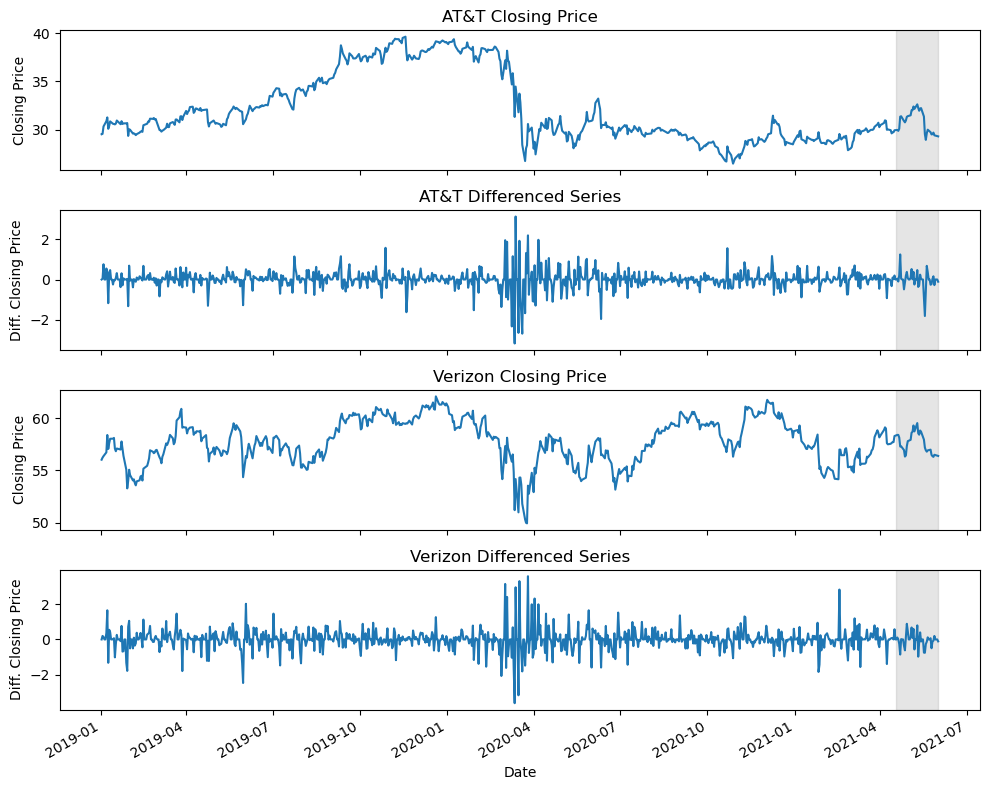

In [132]:
# Let's visualize the testing scenario for AT&T and Verizon.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,
                               figsize=(10, 8))

ax1.plot(t_df.close, label='AT&T Closing Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')
ax1.axvspan(merged_df['close_t'].index[split_point], t_df.index[-1],
            color='#808080', alpha=0.2)
ax1.set_title('AT&T Closing Price')

ax2.plot(merged_df['t_diff'], label='AT&T Diff. Closing Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff. Closing Price')
ax2.axvspan(merged_df['t_diff'].index[split_point], t_df.index[-1],
            color='#808080', alpha=0.2)
ax2.set_title('AT&T Differenced Series')

ax3.plot(v_df.close, label='Verizon Closing Price')
ax3.set_xlabel('Date')
ax3.set_ylabel('Closing Price')
ax3.axvspan(merged_df['close_v'].index[split_point], v_df.index[-1],
            color='#808080', alpha=0.2)
ax3.set_title('Verizon Closing Price')

ax4.plot(merged_df['v_diff'], label='Verizon Diff. Closing Price')
ax4.set_xlabel('Date')
ax4.set_ylabel('Diff. Closing Price')
ax4.axvspan(merged_df['v_diff'].index[split_point], v_df.index[-1],
            color='#808080', alpha=0.2)
ax4.set_title('Verizon Differenced Series')

fig.autofmt_xdate()
plt.tight_layout()

In [133]:
# Let's create a more robust scoring function that calculates the RMSE, MAE, and MAPE for each forecast.

from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)

def evaluate_forecast(actual, predicted):
    rmse = root_mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)*100
    return rmse, mae, mape

In [134]:
from statsmodels.tsa.arima.model import ARIMA

def rolling_ma_forecast(train, test, q):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        # Fit ARIMA model on the current history
        model = ARIMA(history, order=(0, 0, q))
        model_fit = model.fit()

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Append the actual value to history for next step
        history.append(test.iloc[t])

    rmse = root_mean_squared_error(test, predictions)
    predictions = pd.Series(predictions, index=test.index)
    return predictions, rmse

In [135]:
t_ma_predictions, t_ma_rmse = rolling_ma_forecast(t_diff_train, t_diff_test, 1)
v_ma_predictions, v_ma_rmse = rolling_ma_forecast(v_diff_train, v_diff_test, 1)

In [136]:
ma_predictions = pd.concat([t_ma_predictions, v_ma_predictions], keys=['t_ma', 'v_ma'],axis=1)
ma_predictions["t_inv_diff"] = (
    merged_df["close_t"].iloc[split_point] + ma_predictions["t_ma"].cumsum()
)
ma_predictions["v_inv_diff"] = (
    merged_df["close_v"].iloc[split_point] + ma_predictions["v_ma"].cumsum()
)
ma_predictions.head()

,t_ma,v_ma,t_inv_diff,v_inv_diff
timestamp,,,,
2021-04-18,-0.001978,-0.007044,29.948022,58.272956
2021-04-19,0.000262,0.001757,29.948284,58.274713
2021-04-20,-0.003896,-0.011470,29.944388,58.263244
2021-04-21,0.011116,0.001298,29.955503,58.264542
2021-04-22,-0.022620,0.035679,29.932884,58.300220


In [137]:
def visualize_predictions(actual_t, predictions_t, actual_v, predictions_v, method):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 10))

    ax1.plot(actual_t, label="Time Series", c="b")
    ax1.plot(predictions_t, label=f"Predictions ({method})", c="r")
    ax1.legend(loc="best")
    ax1.set_title(f"AT&T Predicted Stock Price ({method})")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("$")
    ax1.legend()

    ax2.plot(actual_v, label="Time Series", c="b")
    ax2.plot(predictions_v, label=f"Predictions ({method})", c="r")
    ax2.legend(loc="best")
    ax2.set_title(f"Verizon Predicted Stock Price ({method})")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("$")
    ax2.legend()

    fig.autofmt_xdate()
    plt.show()

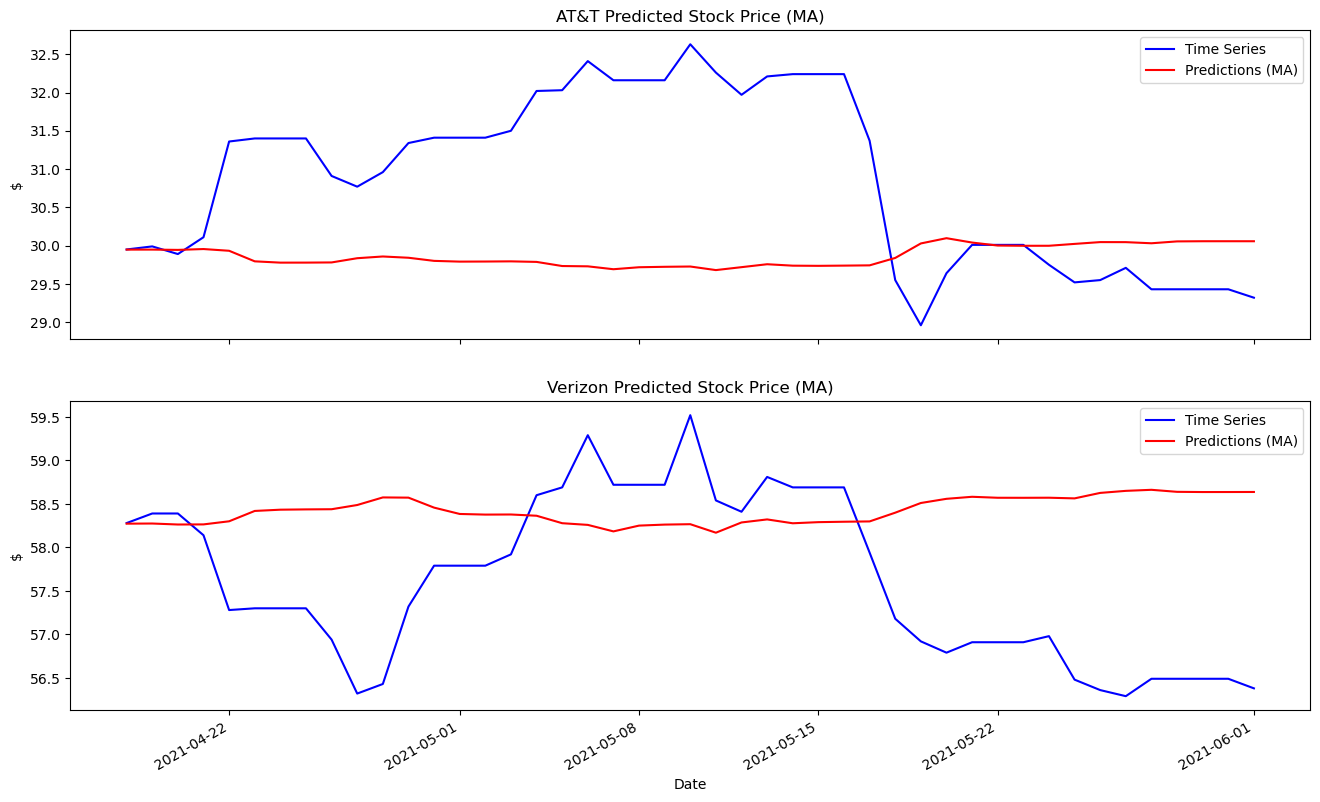

In [138]:
visualize_predictions(t_eval, ma_predictions["t_inv_diff"], v_eval, ma_predictions["v_inv_diff"], "MA")

In [139]:
t_ma_rmse, t_ma_mae, t_ma_mape = evaluate_forecast(t_eval, ma_predictions["t_inv_diff"])
v_ma_rmse, v_ma_mae, v_ma_mape = evaluate_forecast(v_eval, ma_predictions["v_inv_diff"])

print(f"AT&T MA(1) - RMSE: {t_ma_rmse:.4f}, MAE: {t_ma_mae:.4f}, MAPE: {t_ma_mape:.2f}%")
print(f"Verizon MA(1) - RMSE: {v_ma_rmse:.4f}, MAE: {v_ma_mae:.4f}, MAPE: {v_ma_mape:.2f}%")

AT&T MA(1) - RMSE: 1.5879, MAE: 1.2952, MAPE: 4.10%
Verizon MA(1) - RMSE: 1.3387, MAE: 1.1076, MAPE: 1.94%


### Modeling with EWM
We'll use the differenced series to model with exponential moving average.

In [140]:
# Calculate the exponential weighted average
merged_df = merged_df.assign(t_ewm_short=merged_df.close_t.ewm(span=6, adjust=False).mean())
merged_df = merged_df.assign(t_ewm_long=merged_df.close_t.ewm(span=11, adjust=False).mean())
merged_df = merged_df.assign(v_ewm_short=merged_df.close_v.ewm(span=4, adjust=False).mean())
merged_df = merged_df.assign(v_ewm_long=merged_df.close_v.ewm(span=11, adjust=False).mean())

In [141]:
print(f"AT&T Short-Window EWM RMSE: {root_mean_squared_error(merged_df.close_t, merged_df.t_ewm_short):.4f}")
print(f"AT&T Long-Window EWM RMSE: {root_mean_squared_error(merged_df.close_t, merged_df.t_ewm_long):.4f}")
print(f"Verizon Short-Window EWM RMSE: {root_mean_squared_error(merged_df.close_v, merged_df.v_ewm_short):.4f}")
print(f"Verizon Long-Window EWM RMSE: {root_mean_squared_error(merged_df.close_v, merged_df.v_ewm_long):.4f}")

AT&T Short-Window EWM RMSE: 0.4236
AT&T Long-Window EWM RMSE: 0.5979
Verizon Short-Window EWM RMSE: 0.4031
Verizon Long-Window EWM RMSE: 0.7434


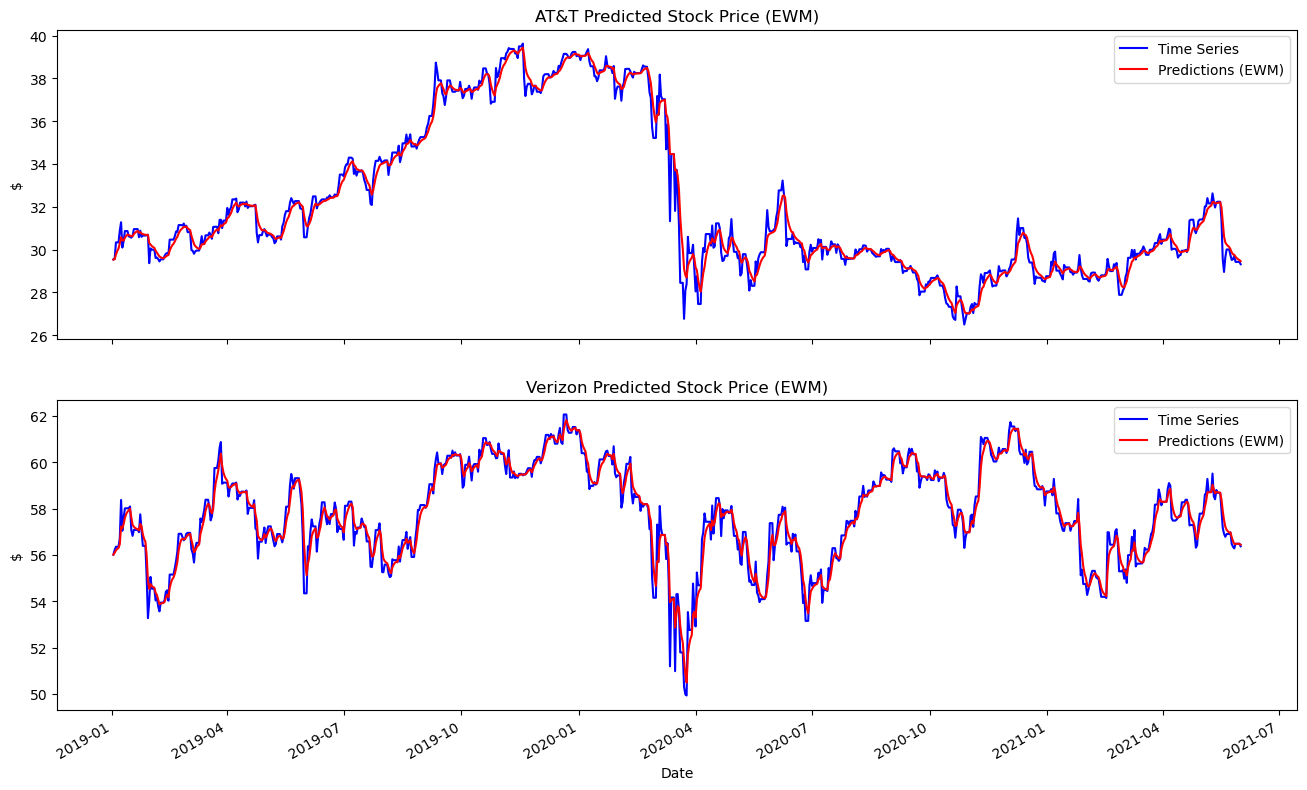

In [142]:
visualize_predictions(merged_df.close_t, merged_df.t_ewm_short, merged_df.close_v, merged_df.v_ewm_short, "EWM")

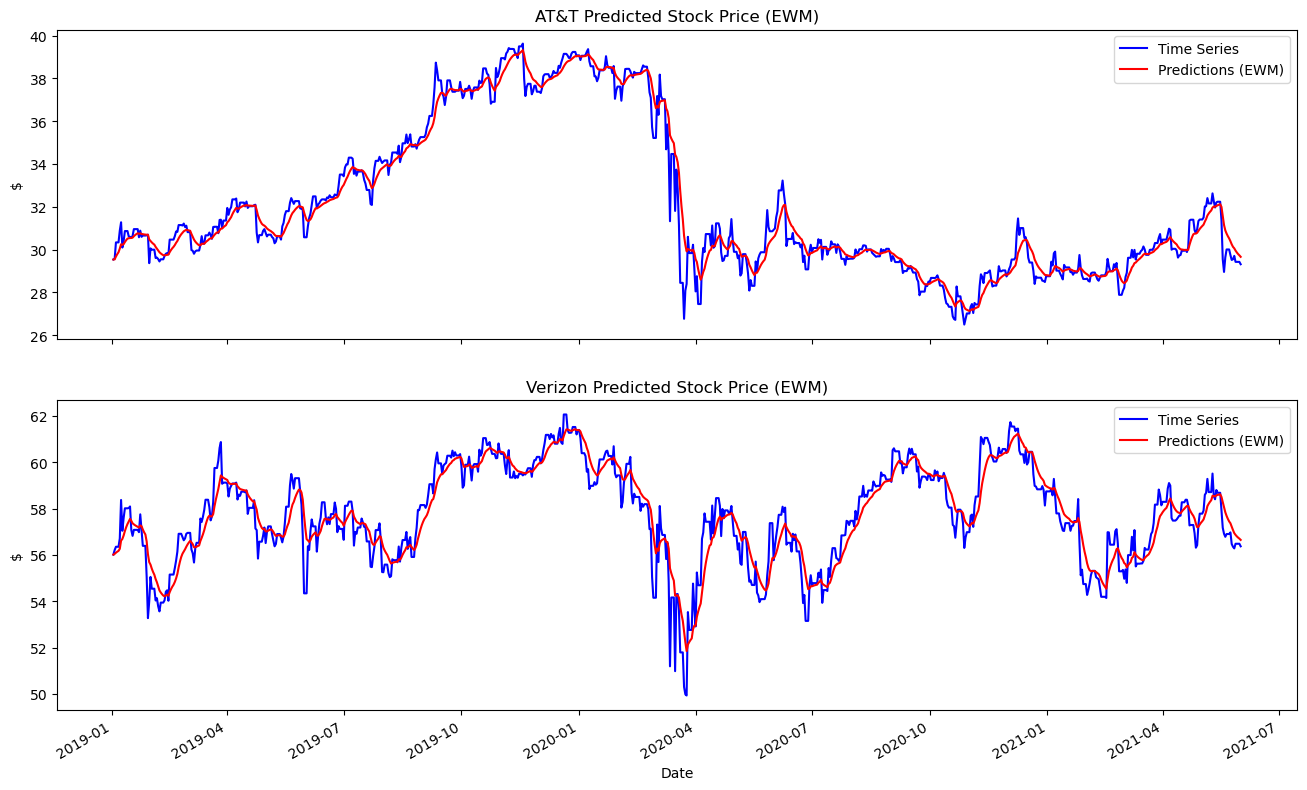

In [143]:
visualize_predictions(merged_df.close_t, merged_df.t_ewm_long, merged_df.close_v, merged_df.v_ewm_long, "EWM")

### Modeling with Autoregressive

In [144]:
# Separating the differenced time series off into their own DataFrames for convenience
t_diff = merged_df.t_diff.asfreq("D")
v_diff = merged_df.v_diff.asfreq("D")

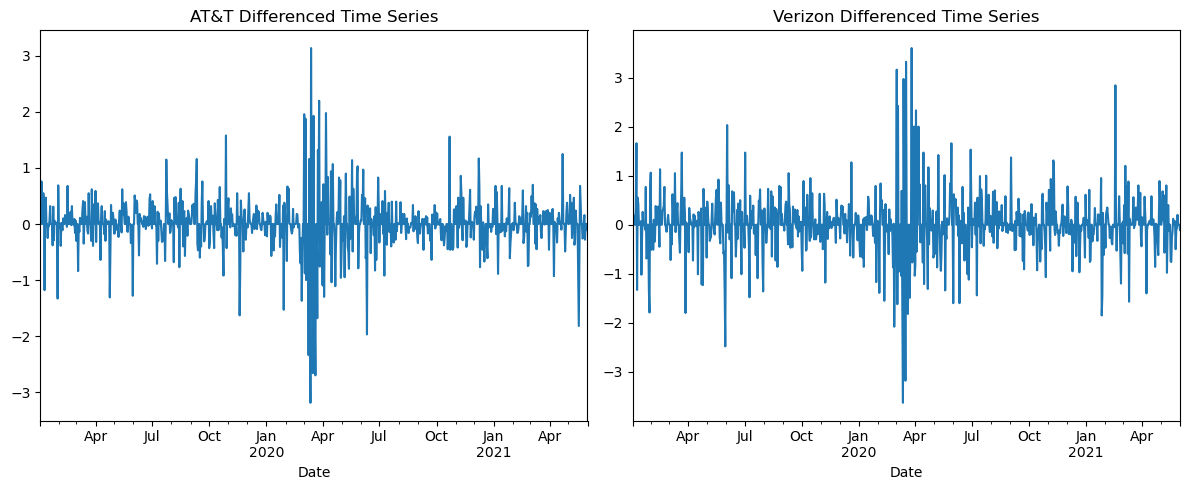

In [145]:
# Let's look at the differenced data.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
t_diff.plot(title="AT&T Differenced Time Series", ax=ax[0])
ax[0].set_xlabel("Date")

# Plot ACF for Verizon Differenced Series
v_diff.plot(title="Verizon Differenced Time Series", ax=ax[1])
ax[1].set_xlabel("Date")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

Both datasets have ADF p-values << 0.05, so we can reject the null hypothesis and conclude that both datasets are stationary. Let's plot the ACF again to see whether there is autocorrelation.

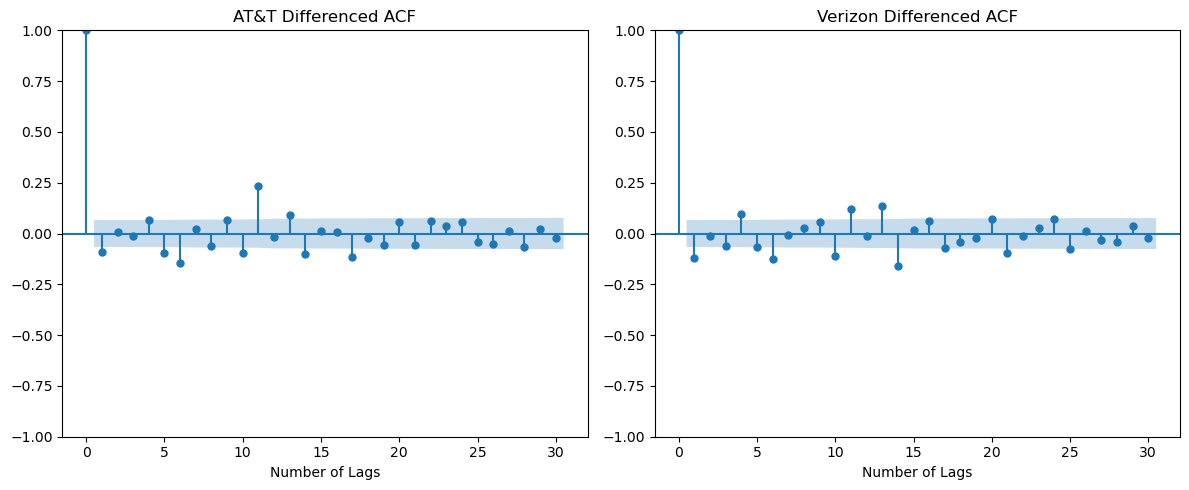

In [146]:
# Plot ACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
plot_acf(t_diff, lags=30, title="AT&T Differenced ACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_acf(v_diff, lags=30, title="Verizon Differenced ACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

A gradually decreasing ACF plot would suggest an autoregressive model. This isn't exactly the case, but it looks like there isn't a clear MA(q) model either. Let's plot the PACF to see if we can determine the order of the AR model.

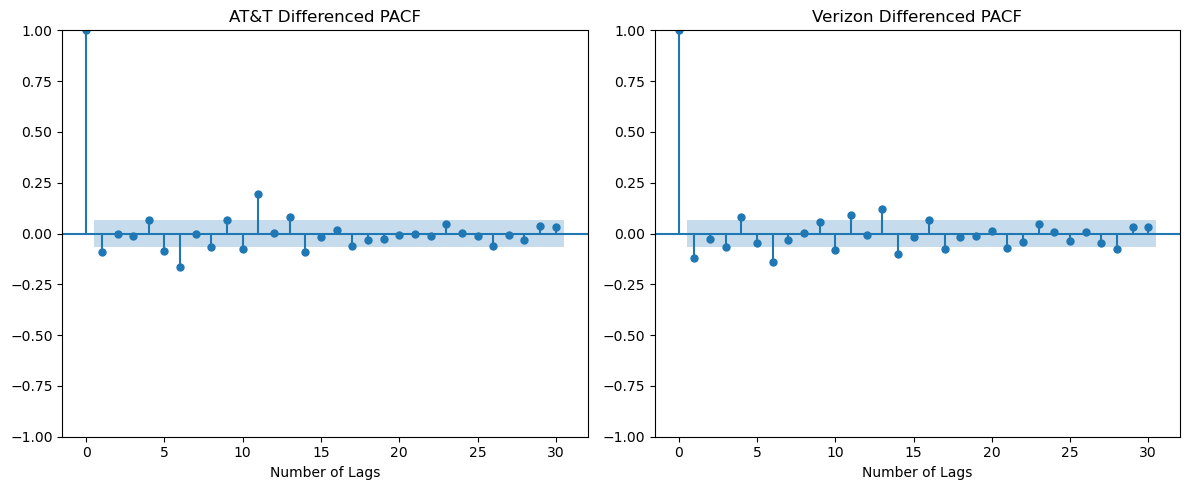

In [147]:
# Plot PACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF for AT&T Differenced Series
plot_pacf(t_diff, lags=30, title="AT&T Differenced PACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_pacf(v_diff, lags=30, title="Verizon Differenced PACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

This looks like an `AR(1)` model for both datasets, though there appears to be some seasonality in both plots. We can look at ARIMA or SARIMA models later to account for this. In the meantime, let's split the data into training and testing sets.

In [148]:
from statsmodels.tsa.ar_model import AutoReg

# Let's optimize the number of lags using the AIC
def select_lag(series, max_lag):
    aic_values = []
    for lag in range(1, max_lag + 1):
        model = AutoReg(series, lags=lag).fit()
        aic_values.append((lag, model.aic))
    optimal_lag = min(aic_values, key=lambda x: x[1])[0]
    return optimal_lag


In [149]:
optimal_lag_t = select_lag(t_diff_train, max_lag=20)
optimal_lag_v = select_lag(v_diff_train, max_lag=20)

print(f'Optimal AT&T Lag: {optimal_lag_t}')
print(f'Optimal Verizon Lag: {optimal_lag_v}')

t_ar = AutoReg(t_diff_train, lags=optimal_lag_t).fit()
v_ar = AutoReg(v_diff_train, lags=optimal_lag_v).fit()

Optimal AT&T Lag: 14
Optimal Verizon Lag: 17


In [150]:
t_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 t_diff   No. Observations:                  837
Model:                    AutoReg(14)   Log Likelihood                -467.423
Method:               Conditional MLE   S.D. of innovations              0.427
Date:                Sat, 25 Jan 2025   AIC                            966.847
Time:                        21:50:50   BIC                           1042.254
Sample:                    01-16-2019   HQIC                           995.776
                         - 04-17-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.015     -0.068      0.946      -0.030       0.028
t_diff.L1     -0.0964      0.035     -2.776      0.005      -0.164      -0.028
t_diff.L2     -0.0267      0.035     -0.769      0.442      -0.095       0.041
t_diff.L3      0.0439      0.035      1.262      0.207      -0.024       0.112
t_diff.L4      0.0604      0.034      1.771      0.077      -0.006       0.127
t_diff.L5     -0.0661      0.034     -1.938      0.053      -0.133       0.001
t_diff.L6     -0.1639      0.034     -4.807      0.000      -0.231      -0.097
t_diff.L7     -0.0347      0.034     -1.007      0.314      -0.102       0.033
t_diff.L8     -0.0592      0.034     -1.721      0.085      -0.127       0.008
t_diff.L9      0.0623      0.034      1.836      0.066      -0.004       0.129
t_diff.L10    -0.0430      0.034     -1.264      0.206      -0.110       0.024
t_diff.L11     0.2043      0.034      6.011      0.000       0.138       0.271
t_diff.L12     0.0105      0.035      0.302      0.762      -0.057       0.078
t_diff.L13     0.0746      0.035      2.152      0.031       0.007       0.142
t_diff.L14    -0.0863      0.035     -2.497      0.013      -0.154      -0.019
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0229           -0.2970j            1.0651           -0.4550
AR.2            -1.0229           +0.2970j            1.0651            0.4550
AR.3            -0.8578           -0.8195j            1.1863           -0.3786
AR.4            -0.8578           +0.8195j            1.1863            0.3786
AR.5            -0.5266           -1.1595j            1.2735           -0.3179
AR.6            -0.5266           +1.1595j            1.2735            0.3179
AR.7            -0.0505           -1.1310j            1.1322           -0.2571
AR.8            -0.0505           +1.1310j            1.1322            0.2571
AR.9             0.4966           -1.0610j            1.1714           -0.1803
AR.10            0.4966           +1.0610j            1.1714            0.1803
AR.11            0.9321           -0.5841j            1.1000           -0.0891
AR.12            0.9321           +0.5841j            1.1000            0.0891
AR.13            1.2814           -0.0000j            1.2814           -0.0000
AR.14            1.6409           -0.0000j            1.6409           -0.0000
------------------------------------------------------------------------------
"""

In [151]:
v_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 v_diff   No. Observations:                  837
Model:                    AutoReg(17)   Log Likelihood                -697.422
Method:               Conditional MLE   S.D. of innovations              0.566
Date:                Sat, 25 Jan 2025   AIC                           1432.843
Time:                        21:50:50   BIC                           1522.320
Sample:                    01-19-2019   HQIC                          1467.176
                         - 04-17-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.020      0.065      0.948      -0.037       0.040
v_diff.L1     -0.0965      0.035     -2.771      0.006      -0.165      -0.028
v_diff.L2     -0.0242      0.035     -0.692      0.489      -0.093       0.044
v_diff.L3     -0.0553      0.035     -1.585      0.113      -0.124       0.013
v_diff.L4      0.0569      0.035      1.638      0.101      -0.011       0.125
v_diff.L5     -0.0710      0.034     -2.060      0.039      -0.139      -0.003
v_diff.L6     -0.1135      0.035     -3.283      0.001      -0.181      -0.046
v_diff.L7     -0.0336      0.035     -0.970      0.332      -0.102       0.034
v_diff.L8      0.0210      0.035      0.607      0.544      -0.047       0.089
v_diff.L9      0.0413      0.035      1.193      0.233      -0.027       0.109
v_diff.L10    -0.0580      0.035     -1.673      0.094      -0.126       0.010
v_diff.L11     0.0887      0.035      2.566      0.010       0.021       0.156
v_diff.L12     0.0008      0.034      0.024      0.981      -0.067       0.068
v_diff.L13     0.1234      0.034      3.588      0.000       0.056       0.191
v_diff.L14    -0.1077      0.035     -3.114      0.002      -0.175      -0.040
v_diff.L15    -0.0165      0.035     -0.474      0.636      -0.085       0.052
v_diff.L16     0.0615      0.035      1.770      0.077      -0.007       0.130
v_diff.L17    -0.0740      0.035     -2.137      0.033      -0.142      -0.006
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0327           -0.3070j            1.0774           -0.4540
AR.2            -1.0327           +0.3070j            1.0774            0.4540
AR.3            -0.8023           -0.7383j            1.0903           -0.3816
AR.4            -0.8023           +0.7383j            1.0903            0.3816
AR.5            -1.2996           -0.0000j            1.2996           -0.5000
AR.6            -0.4534           -1.0162j            1.1128           -0.3168
AR.7            -0.4534           +1.0162j            1.1128            0.3168
AR.8            -0.0090           -1.0816j            1.0817           -0.2513
AR.9            -0.0090           +1.0816j            1.0817            0.2513
AR.10            1.2224           -0.2039j            1.2393           -0.0263
AR.11            1.2224           +0.2039j            1.2393            0.0263
AR.12            0.9523           -0.6018j            1.1265           -0.0897
AR.13            0.9523           +0.6018j            1.1265            0.0897
AR.14            0.4683           -1.1962j            1.2846           -0.1906
AR.15            0.4683           +1.1962j            1.2846            0.1906
AR.16            0.7199           -1.0488j            1.2720           -0.1543
AR

In [152]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

def rolling_ar_forecast(train, test, lags):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = AutoReg(history, lags=lags).fit()
        pred = model.predict(start=len(history), end=len(history))
        predictions.append(pred[0])
        history.append(test.iloc[t])
        
    predictions = pd.Series(predictions, index=test.index)
    rmse = root_mean_squared_error(test, predictions)
    return predictions, rmse


In [153]:
t_predictions, t_rmse = rolling_ar_forecast(
    t_diff_train, t_diff_test, lags=optimal_lag_t
)
v_predictions, v_rmse = rolling_ar_forecast(
    v_diff_train, v_diff_test, lags=optimal_lag_v
)

In [154]:
ar_predictions = pd.concat([t_predictions, v_predictions], keys=["t_ar", "v_ar"], axis=1)
ar_predictions["t_inv_diff"] = merged_df["close_t"].iloc[split_point] + ar_predictions["t_ar"].cumsum()
ar_predictions["v_inv_diff"] = merged_df["close_v"].iloc[split_point] + ar_predictions["v_ar"].cumsum()
ar_predictions.head()

,t_ar,v_ar,t_inv_diff,v_inv_diff
timestamp,,,,
2021-04-18,0.088477,0.106826,30.038477,58.386826
2021-04-19,-0.133851,-0.197246,29.904626,58.189580
2021-04-20,-0.022497,-0.045570,29.882129,58.144010
2021-04-21,-0.062680,-0.171278,29.819448,57.972732
2021-04-22,0.009224,0.066354,29.828672,58.039086


In [155]:
t_ar_rmse, t_ar_mae, t_ar_mape = evaluate_forecast(t_eval, ar_predictions["t_inv_diff"])
v_ar_rmse, v_ar_mae, v_ar_mape = evaluate_forecast(v_eval, ar_predictions["v_inv_diff"])

print(
    f"AT&T AR({optimal_lag_t}) - RMSE: {t_ar_rmse:.4f}, MAE: {t_ar_mae:.4f}, MAPE: {t_ar_mape:.2f}%"
)
print(
    f"Verizon AR({optimal_lag_v}) - RMSE: {v_ar_rmse:.4f}, MAE: {v_ar_mae:.4f}, MAPE: {v_ar_mape:.2f}%"
)

AT&T AR(14) - RMSE: 1.7401, MAE: 1.4217, MAPE: 4.50%
Verizon AR(17) - RMSE: 1.2996, MAE: 1.1181, MAPE: 1.95%


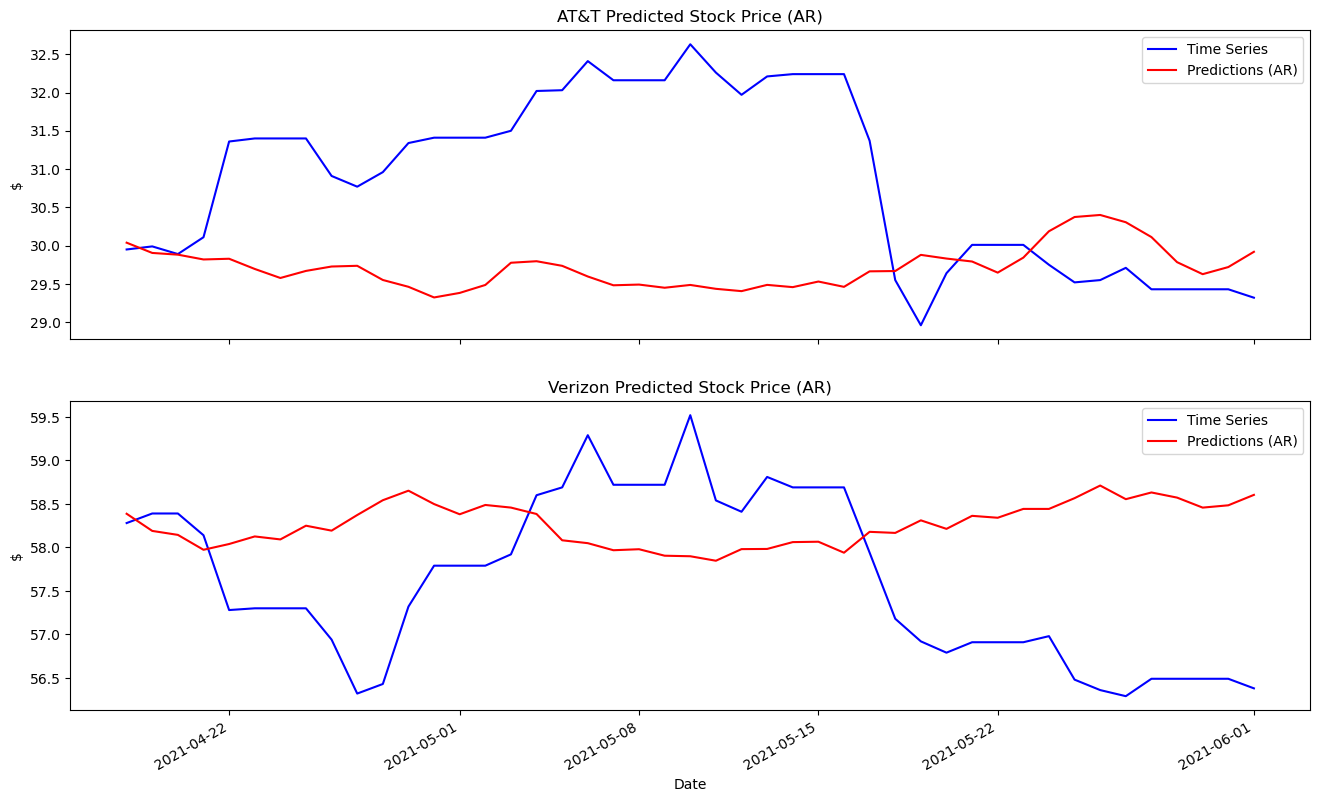

In [156]:
visualize_predictions(t_eval, ar_predictions["t_inv_diff"], v_eval, ar_predictions["v_inv_diff"], "AR")

### Modeling with ARIMA (Autoregressive Integrated Moving Average)
We'll use the ARIMA model to forecast the differenced series. The ARIMA model is a generalization of an autoregressive moving average (ARMA) model. It has three components: autoregressive (AR), differencing (I), and moving average (MA). The ARIMA model is suitable for non-stationary data.

In [157]:
# Create new Series with the original closing prices
t_close = merged_df.close_t.asfreq('D')
v_close = merged_df.close_v.asfreq('D')

# Make sure both datasets are the same length to use a single split point
assert len(t_close) == len(v_close)

# Creating split points to maintain temporal integrity
split_point = int(len(t_close) * 0.95)

t_arima_train = t_close.iloc[:split_point]
t_arima_test = t_close.iloc[split_point:]
v_arima_train = v_close.iloc[:split_point]
v_arima_test = v_close.iloc[split_point:]

In [158]:
v_arima_train.describe()

count       837.0
mean     57.78307
std      2.115954
min         49.94
25%         56.45
50%         57.89
75%         59.44
max         62.07
Name: close_v, dtype: Float64

In [159]:
# Define a function that fits many ARIMA(p,d,q) models to the training data and returns the best one.
# Courtesy of Marco Peixeiro's book, "Time Series Forecasting with Python"

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA


def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit(
                method_kwargs={'maxiter': 500})
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Failed to fit model {order}: {str(e)}")
            continue

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(
        by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [160]:
# Define the p and q parameters to take any value between 0 and 10.
from itertools import product
ps = range(0, 3, 1)
qs = range(0, 3, 1)
d = 1
order_list = list(product(ps, qs)) 

In [161]:
t_result_df = optimize_ARIMA(t_arima_train, order_list, d)
v_result_df = optimize_ARIMA(v_arima_train, order_list, d)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [162]:
print(f"Best p, q parameters for AT&T: {t_result_df['(p,q)'].iloc[0]}. AIC: {t_result_df['AIC'].iloc[0]}")
print(f"Best p, q parameters for Verizon: {v_result_df['(p,q)'].iloc[0]}. AIC: {v_result_df['AIC'].iloc[0]}")

Best p, q parameters for AT&T: (2, 2). AIC: 1033.4926415017344
Best p, q parameters for Verizon: (2, 1). AIC: 1503.2944923721002


In [163]:
t_model = ARIMA(t_arima_train, order=(2, 1, 2))
v_model = ARIMA(v_arima_train, order=(2, 1, 1))
t_model_fit = t_model.fit(method_kwargs={'maxiter': 500})
v_model_fit = v_model.fit(method_kwargs={'maxiter': 500})

In [164]:
print(f'AT&T Model Summary:\n {t_model_fit.summary()}\n')
print(f'Verizon Model Summary:\n{v_model_fit.summary()}')

AT&T Model Summary:
                                SARIMAX Results                                
Dep. Variable:                close_t   No. Observations:                  837
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -511.746
Date:                Sat, 25 Jan 2025   AIC                           1033.493
Time:                        21:50:52   BIC                           1057.136
Sample:                    01-02-2019   HQIC                          1042.556
                         - 04-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8265      0.029    -62.618      0.000      -1.884      -1.769
ar.L2         -0.8808      0.029    -30.612      0.000      -0.937      -0.824
ma.L1          1.7634      0.03

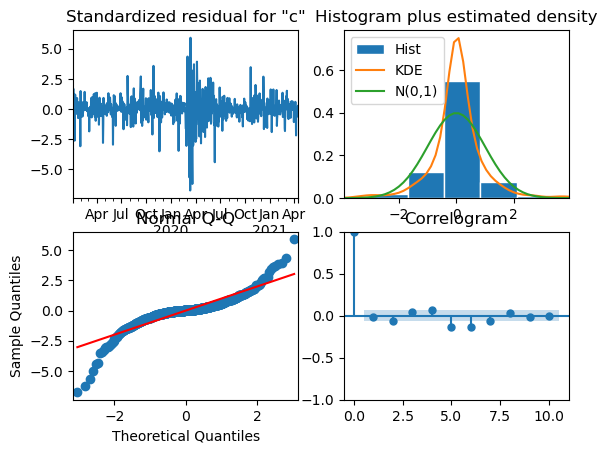

In [165]:
t_model_fit.plot_diagnostics()
plt.show()

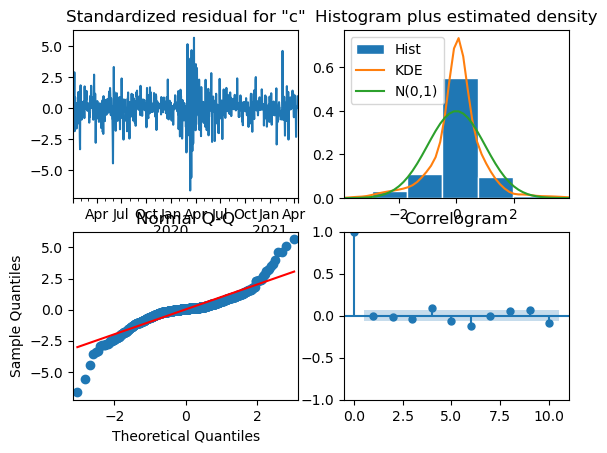

In [166]:
v_model_fit.plot_diagnostics()
plt.show()

In [167]:
# Check the residuals using the Ljung-Box test. 
# If p-values < 0.05, the residuals are not white noise.
from statsmodels.stats.diagnostic import acorr_ljungbox

t_residuals = t_model_fit.resid
v_residuals = v_model_fit.resid

print(f'AT&T Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(t_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}')
print(f'Verizon Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(v_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}')

AT&T Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.000862   0.976573
2   0.114247   0.944478
3   0.171820   0.982005
4   0.263495   0.992047
5   0.281930   0.997969
6   0.349383   0.999220
7   1.910828   0.964610
8   2.000282   0.981003
9   2.146774   0.988928
10  2.146944   0.995085
Verizon Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.006972   0.933457
2   0.007905   0.996055
3   0.015676   0.999480
4   0.069453   0.999411
5   0.069779   0.999933
6   0.308326   0.999456
7   0.597111   0.999008
8   0.701538   0.999523
9   0.854459   0.999706
10  0.885871   0.999902


In [168]:
from statsmodels.tsa.arima.model import ARIMA

def rolling_arima_forecast(train, test, order):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        # Fit ARIMA model on the current history
        model = ARIMA(history, order=order)
        model_fit = model.fit(method_kwargs={"maxiter": 500})

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Append the actual value to history for next step
        history.append(test.iloc[t])
    
    rmse = root_mean_squared_error(test, predictions)
    predictions = pd.Series(predictions, index=test.index)
    return predictions, rmse

In [169]:
t_arima_rolling, t_arima_rmse = rolling_arima_forecast(t_arima_train, t_arima_test, (2, 1, 2))
v_arima_rolling, v_arima_rmse = rolling_arima_forecast(v_arima_train, v_arima_test, (2, 1, 1))

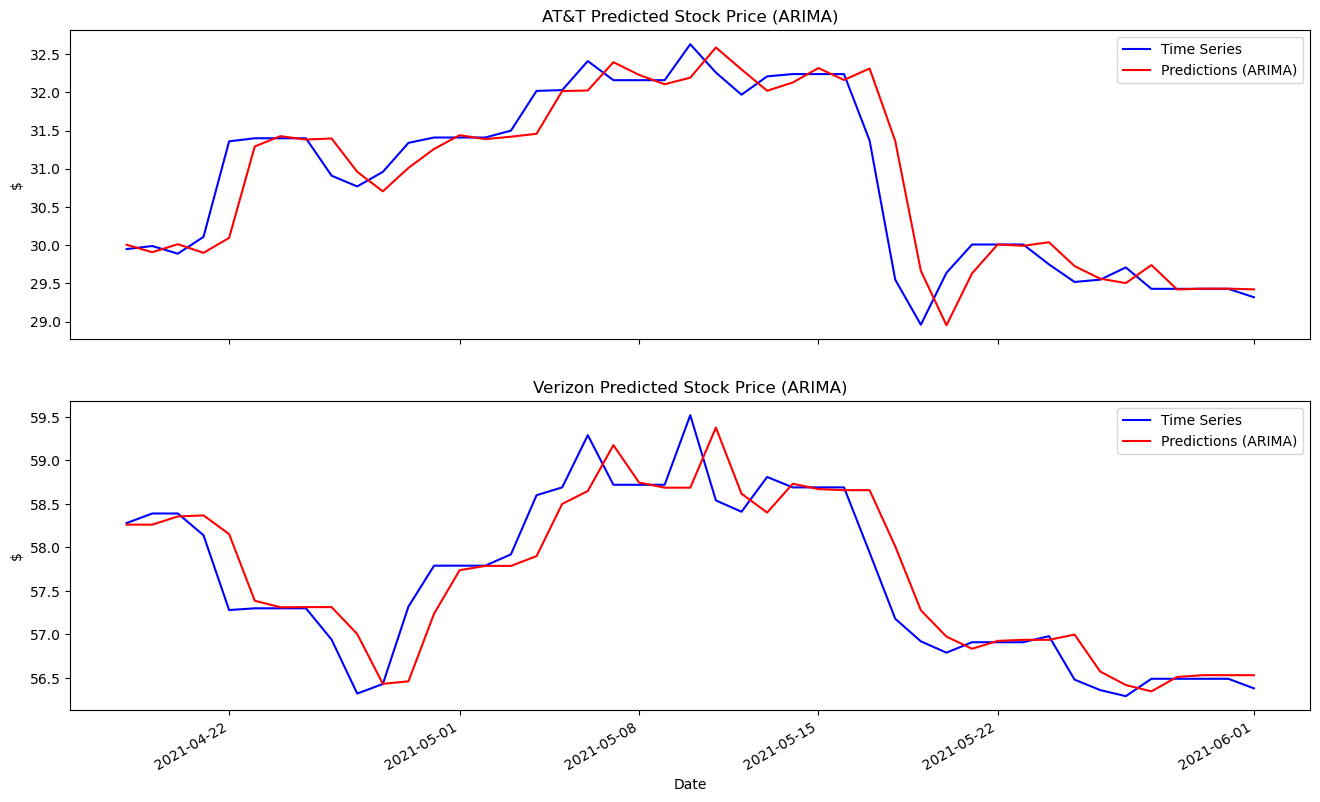

In [170]:
visualize_predictions(t_arima_test, t_arima_rolling, v_arima_test, v_arima_rolling, "ARIMA")

In [171]:
t_arima_rmse, t_arima_mae, t_arima_mape = evaluate_forecast(t_eval, t_arima_rolling)
v_arima_rmse, v_arima_mae, v_arima_mape = evaluate_forecast(v_eval, v_arima_rolling)

print(
    f"AT&T ARIMA - RMSE: {t_arima_rmse:.4f}, MAE: {t_arima_mae:.4f}, MAPE: {t_arima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_arima_rmse:.4f}, MAE: {v_arima_mae:.4f}, MAPE: {v_arima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.4402, MAE: 0.2663, MAPE: 0.87%
Verizon ARIMA - RMSE: 0.3951, MAE: 0.2665, MAPE: 0.46%


### Modeling with SARIMA (Seasonal ARIMA)
`SARIMAX` models are `Seasonal AutoRegressive Integrated Moving Average` models. They are a generalization of the `ARIMA` models that include seasonality, which should be helpful due to the previously-observed seven-day trends in the data. The workflow for SARIMA models is the same as for ARIMA models, but with an additional step to identify the seasonal order `(P, D, Q, s)`. One does the non-seasonal difference `d` first, then the seasonal difference `D`. Then one plots the ACF and PACF to determine the seasonal order `(P, Q)`. Let's look at using `SARIMA` models to forecast the time series data. 

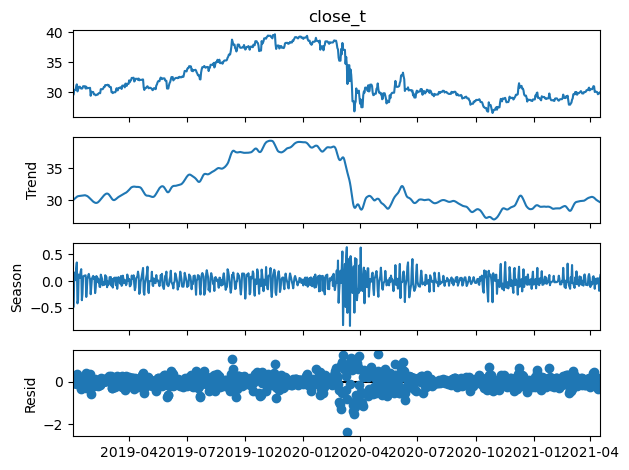

In [172]:
# Perform STL decomposition on the AT&T dataset
from statsmodels.tsa.seasonal import STL

t_stl = STL(t_arima_train, period=7)
t_stl = t_stl.fit()

# Plot the decomposition
t_stl.plot()
plt.show()

<Axes: xlabel='timestamp'>

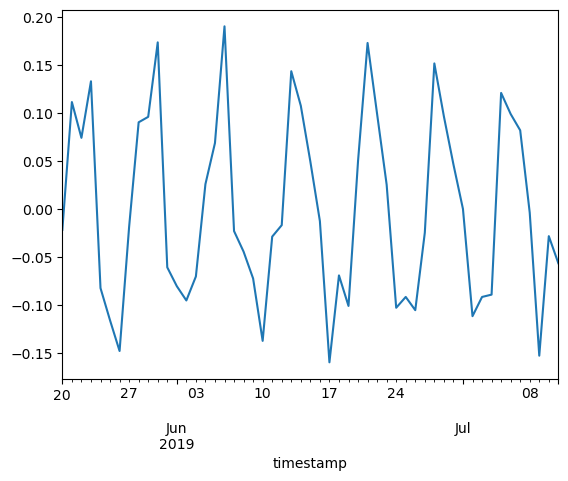

In [173]:
t_stl.seasonal["2019-05-20":"2019-07-11"].plot()

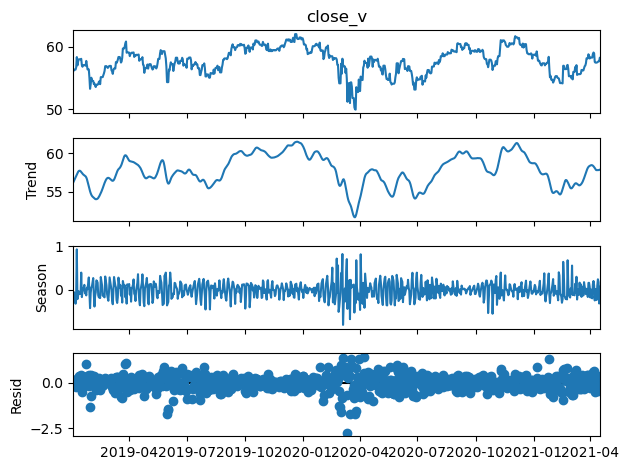

In [174]:
# Perform STL decomposition on the Verizon dataset
v_stl = STL(v_arima_train, period=7)
v_stl = v_stl.fit()

# Plot the decomposition
v_stl.plot()
plt.show()

<Axes: xlabel='timestamp'>

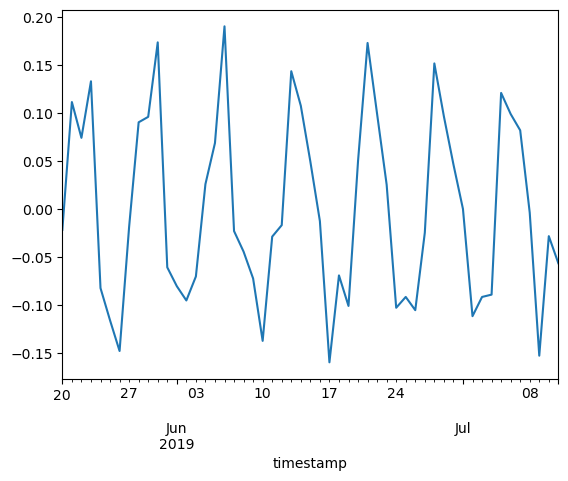

In [175]:
t_stl.seasonal["2019-05-20":"2019-07-11"].plot()

In [176]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from joblib import Parallel, delayed


def optimize_SARIMA_parallelized(
    endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int
) -> pd.DataFrame:

    def fit_order(order):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False,
            ).fit(disp=False)
            aic = model.aic
            return [order, aic]
        except Exception as e:
            print(f"Failed for order {order}: {e}")
            return None

    results = Parallel(n_jobs=-1)(
        delayed(fit_order)(order)
        for order in tqdm(order_list, desc="Optimizing SARIMA")
    )

    # Remove None results
    results = [r for r in results if r is not None]

    result_df = pd.DataFrame(results, columns=["(p,q,P,Q)", "AIC"])

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

In [177]:
# Define the SARIMA parameters
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

d = 1
D = 1
s = 7

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [178]:
t_sarima_params_df = optimize_SARIMA_parallelized(
    t_arima_train, SARIMA_order_list, d, D, s
)
v_sarima_params_df = optimize_SARIMA_parallelized(
    v_arima_train, SARIMA_order_list, d, D, s
)
print(f"Best AT&T SARIMA parameters: {t_sarima_params_df['(p,q,P,Q)'].iloc[0]}. AIC: {t_sarima_params_df['AIC'].iloc[0]}")
print(f"Best Verizon SARIMA parameters: {v_sarima_params_df['(p,q,P,Q)'].iloc[0]}. AIC: {v_sarima_params_df['AIC'].iloc[0]}")

Optimizing SARIMA:   0%|          | 0/81 [00:00<?, ?it/s]

/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-

Optimizing SARIMA:   0%|          | 0/81 [00:00<?, ?it/s]

/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-

Best AT&T SARIMA parameters: (1, 0, 2, 2). AIC: 1075.0354122024582
Best Verizon SARIMA parameters: (0, 1, 2, 1). AIC: 1517.9983517710575


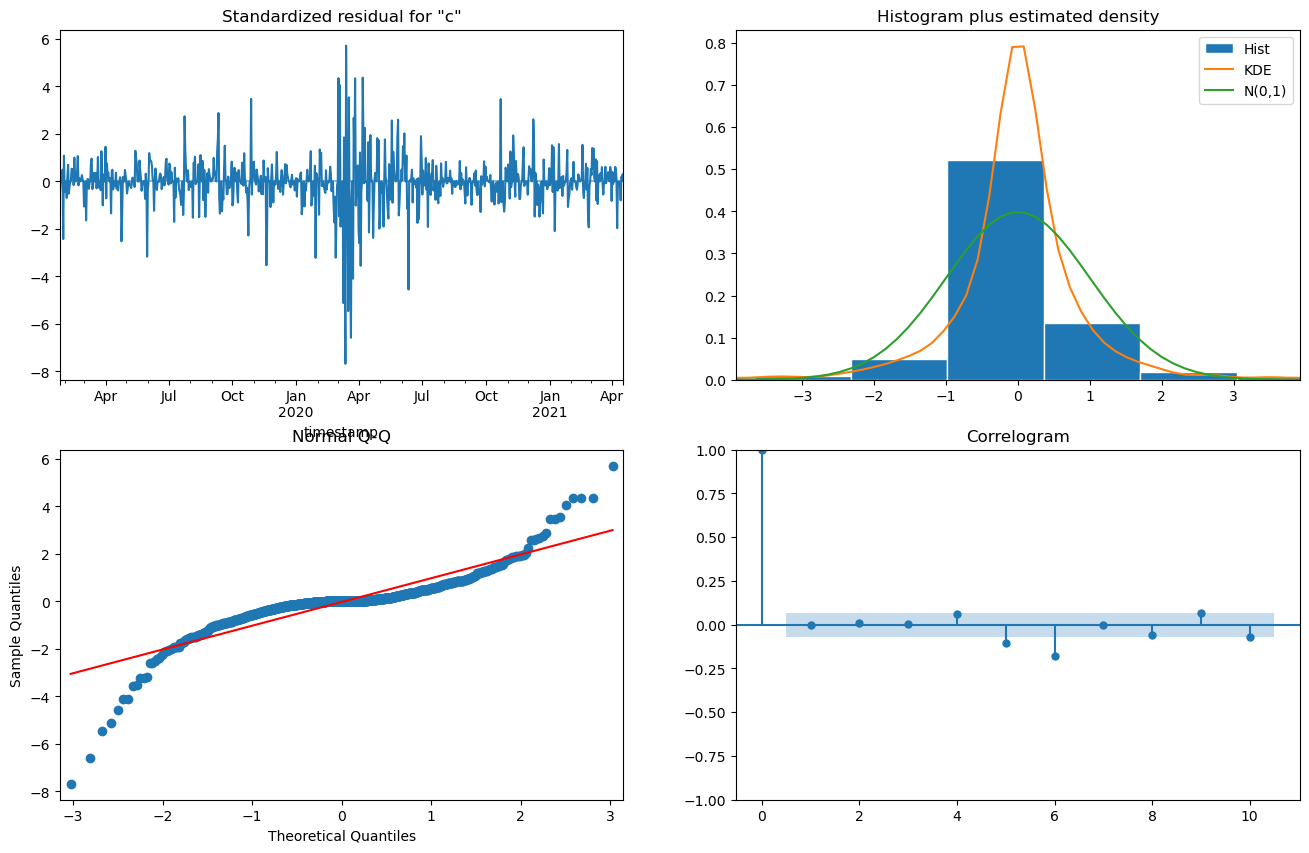

In [179]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming the best parameters are (p, q, P, Q)
best_order_t = t_sarima_params_df["(p,q,P,Q)"].iloc[0]
best_p, best_q, best_P, best_Q = best_order_t
D = 1
s = 7

# Train the SARIMA model with D=1
t_SARIMA_model = SARIMAX(
    t_arima_train,
    order=(best_p, d, best_q),
    seasonal_order=(best_P, D, best_Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
t_SARIMA_model_fit = t_SARIMA_model.fit(disp=False)

# Diagnostic Plots
t_SARIMA_model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

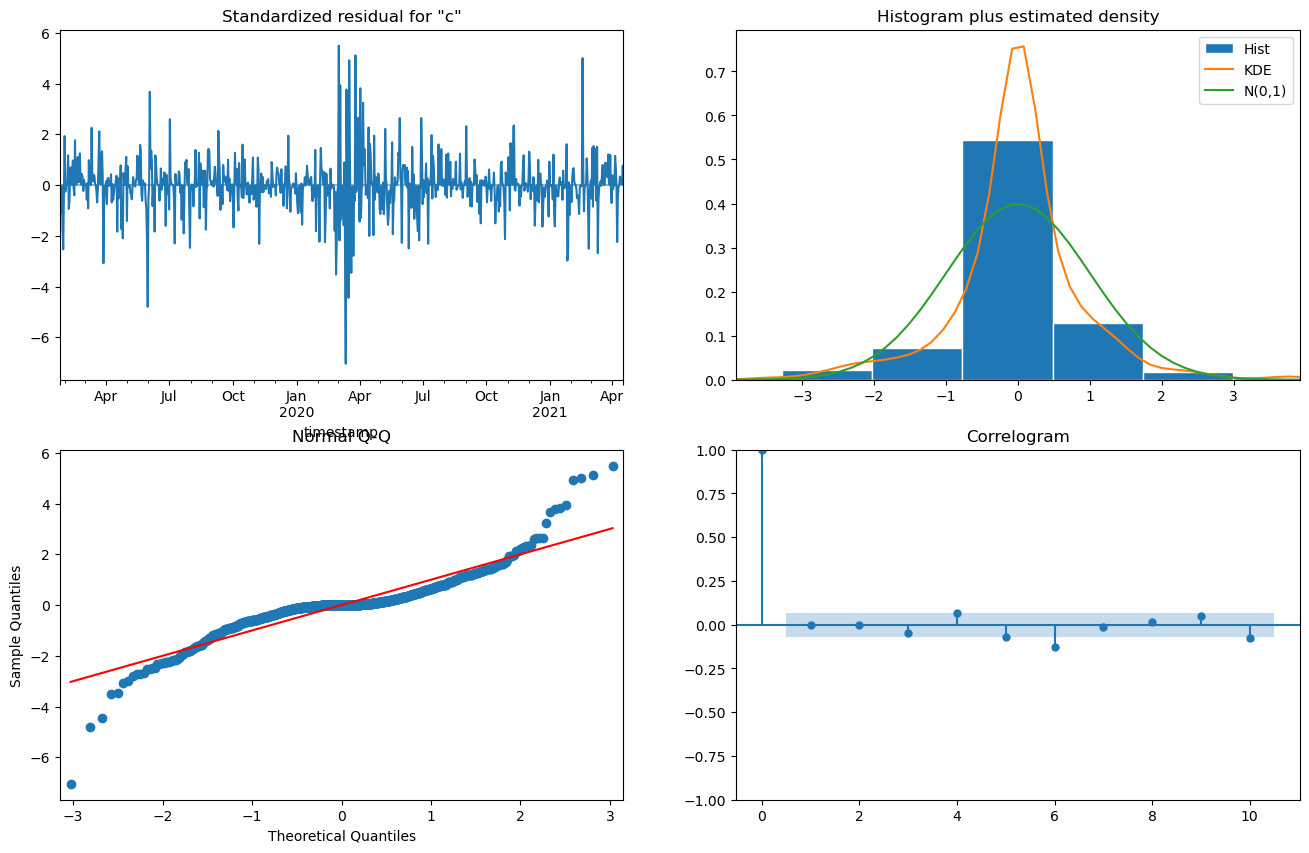

In [180]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming the best parameters are (p, q, P, Q)
best_order_v = v_sarima_params_df["(p,q,P,Q)"].iloc[0]
best_p, best_q, best_P, best_Q = best_order_v
D = 1
s = 7

# Train the SARIMA model with D=1
v_SARIMA_model = SARIMAX(
    v_arima_train,
    order=(best_p, d, best_q),
    seasonal_order=(best_P, D, best_Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
v_SARIMA_model_fit = v_SARIMA_model.fit(disp=False)

# Diagnostic Plots
v_SARIMA_model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

In [181]:
# Check the residuals using the Ljung-Box test.
# If p-values < 0.05, the residuals are not white noise.
from statsmodels.stats.diagnostic import acorr_ljungbox

t_sarima_residuals = t_SARIMA_model_fit.resid
v_sarima_residuals = v_SARIMA_model_fit.resid

print(
    f"AT&T Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(t_sarima_residuals, lags=np.arange(1,15,1).tolist(), return_df=True)}"
)
print(
    f"Verizon Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(v_sarima_residuals, lags=np.arange(1,15,1).tolist(), return_df=True)}"
)

AT&T Ljung-Box analysis, first 10 residuals:
        lb_stat     lb_pvalue
1     1.043564  3.069941e-01
2     1.171060  5.568108e-01
3     1.176361  7.586794e-01
4     1.233768  8.725082e-01
5     1.234004  9.415739e-01
6     1.660835  9.481046e-01
7   118.558155  1.529288e-22
8   119.151313  4.962757e-22
9   119.192851  1.954553e-21
10  119.262830  7.140181e-21
11  119.928102  1.874407e-20
12  120.138268  5.800113e-20
13  120.205112  1.833974e-19
14  120.872257  4.245558e-19
Verizon Ljung-Box analysis, first 10 residuals:
        lb_stat     lb_pvalue
1     0.142830  7.054839e-01
2     0.150909  9.273221e-01
3     0.155175  9.844789e-01
4     0.172498  9.964877e-01
5     0.177167  9.993402e-01
6     0.632584  9.958321e-01
7   171.523897  1.197884e-33
8   171.634702  5.859228e-33
9   171.680777  2.755051e-32
10  171.695820  1.235672e-31
11  171.735272  5.183531e-31
12  171.747216  2.096103e-30
13  171.852652  7.753787e-30
14  172.630272  2.013252e-29


In [182]:
# order = (p, d, q, P, D, Q, s)
def rolling_sarima_forecast(train, test, order):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        # Fit ARIMA model on the current history
        model = SARIMAX(
            history,
            order=(order[0], order[1], order[2]),
            seasonal_order=(order[3], order[4], order[5], order[6]),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Append the actual value to history for next step
        history.append(test.iloc[t])

    rmse = root_mean_squared_error(test, predictions)
    predictions = pd.Series(predictions, index=test.index)
    return predictions, rmse

In [183]:
t_order = (
    best_order_t[0],
    d,
    best_order_t[1],
    best_order_t[2],
    D,
    best_order_t[3],
    s,
)
v_order = (
    best_order_v[0],
    d,
    best_order_v[1],
    best_order_v[2],
    D,
    best_order_v[3],
    s,
)
t_sarima_rolling, t_sarima_rmse = rolling_sarima_forecast(t_arima_train, t_arima_test, t_order)
v_sarima_rolling, v_sarima_rmse = rolling_sarima_forecast(v_arima_train, v_arima_test, v_order)

In [184]:
# (p, d, q, P, D, Q, s)
print(f't_order: {t_order}')
print(f'v_order: {v_order}')

t_order: (1, 1, 0, 2, 1, 2, 7)
v_order: (0, 1, 1, 2, 1, 1, 7)


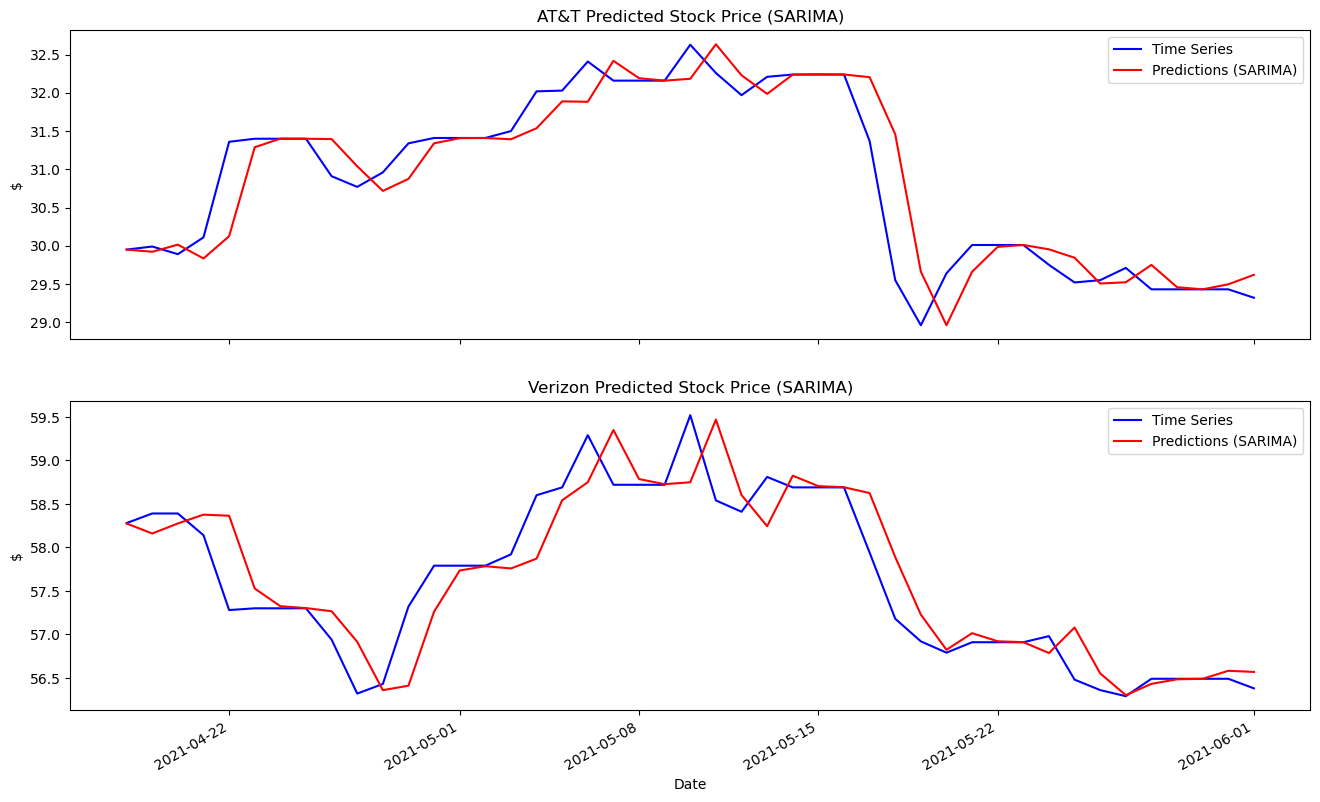

In [185]:
visualize_predictions(t_arima_test, t_sarima_rolling, v_arima_test, v_sarima_rolling, "SARIMA")

In [186]:
residuals = t_SARIMA_model_fit.resid
ljungbox_results = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(ljungbox_results)

       lb_stat     lb_pvalue
1     1.043564  3.069941e-01
2     1.171060  5.568108e-01
3     1.176361  7.586794e-01
4     1.233768  8.725082e-01
5     1.234004  9.415739e-01
6     1.660835  9.481046e-01
7   118.558155  1.529288e-22
8   119.151313  4.962757e-22
9   119.192851  1.954553e-21
10  119.262830  7.140181e-21


In [187]:
# The autocorrelated residuals are confounding.
# I could use Fourier terms as exogenous variables, but that may be overkill.
t_sarima_rmse, t_sarima_mae, t_sarima_mape = evaluate_forecast(t_eval, t_sarima_rolling)
v_sarima_rmse, v_sarima_mae, v_sarima_mape = evaluate_forecast(v_eval, v_sarima_rolling)

print(
    f"AT&T ARIMA - RMSE: {t_sarima_rmse:.4f}, MAE: {t_sarima_mae:.4f}, MAPE: {t_sarima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_sarima_rmse:.4f}, MAE: {v_sarima_mae:.4f}, MAPE: {v_sarima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.4493, MAE: 0.2707, MAPE: 0.88%
Verizon ARIMA - RMSE: 0.4107, MAE: 0.2778, MAPE: 0.48%


### Modeling with `auto_arima`

In [188]:
import pmdarima as pm

## Fit auto_arima for AT&T data
auto_model_t = pm.auto_arima(
    t_arima_train,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    d=1,
    D=1,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model_t.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1619.178, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1435.524, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1621.169, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1335.977, Time=1.35 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=1291.820, Time=1.68 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=5.18 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=6.17 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1300.657, Time=1.08 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=1293.630, Time=2.63 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=1293.567, Time=4.13 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=1292.325, Time=1.89 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=1295.598, Time=6.29 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=1293.816, Time=3.64 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7]          
T

In [189]:
# Fit auto_arima for Verizon data
auto_model_v = pm.auto_arima(
    v_arima_train,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    d=1,
    D=1,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model_v.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2085.576, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1917.013, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.28 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2083.108, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1811.209, Time=1.63 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=1746.585, Time=2.35 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=9.98 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=7.40 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1756.152, Time=1.20 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=1748.148, Time=2.64 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=inf, Time=11.98 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=1746.062, Time=2.02 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=1810.525, Time=1.91 sec
 ARIMA(0,1,1)(3,1,1)[7]             : AIC=inf, Time=9.46 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=7.35 

In [190]:
t_pda_order = (1, 1, 0, 3, 1, 0, 7)
v_pda_order = (0, 1, 1, 3, 1, 0, 7)
t_pdarima_rolling, t_pdarima_rmse = rolling_sarima_forecast(
    t_arima_train, t_arima_test, t_pda_order
)
v_pdarima_rolling, v_pdarima_rmse = rolling_sarima_forecast(
    v_arima_train, v_arima_test, v_pda_order
)


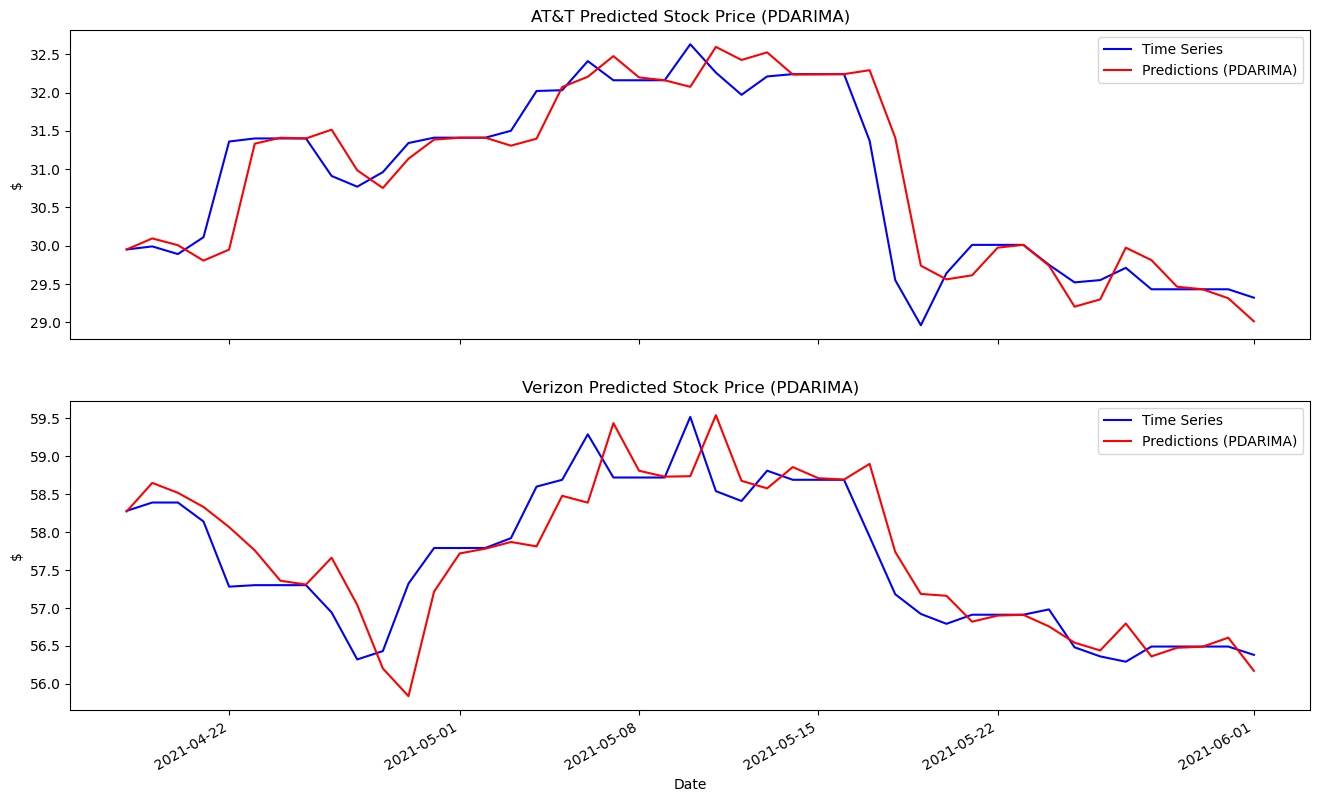

In [191]:
visualize_predictions(t_arima_test, t_pdarima_rolling, v_arima_test, v_pdarima_rolling, "PDARIMA")

In [192]:
t_pdarima_rmse, t_pdarima_mae, t_pdarima_mape = evaluate_forecast(t_eval, t_pdarima_rolling)
v_pdarima_rmse, v_pdarima_mae, v_pdarima_mape = evaluate_forecast(v_eval, v_pdarima_rolling)

print(
    f"AT&T ARIMA - RMSE: {t_pdarima_rmse:.4f}, MAE: {t_pdarima_mae:.4f}, MAPE: {t_pdarima_mape:.2f}%"
)
print(
    f"Verizon ARIMA - RMSE: {v_pdarima_rmse:.4f}, MAE: {v_pdarima_mae:.4f}, MAPE: {v_pdarima_mape:.2f}%"
)

AT&T ARIMA - RMSE: 0.4590, MAE: 0.2692, MAPE: 0.88%
Verizon ARIMA - RMSE: 0.4761, MAE: 0.3235, MAPE: 0.56%
